# Feature extraction

{{ badge }}

### Npil slope coeffisient

In [2]:
### There is no bleaching, so we can record over extended periods of time

### 

### Important variables

- n_peaks
- width.median
- height.median
- decay time


- width.sum
- skewness
- integral
- baseline
- number of active neurons

- correlation
- absolute correlation


- baseline (baseline change)
- median of baselines


- kurtosis?

### Save as pdf without code
https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code?noredirect=1&lq=1


In [14]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

plt.rcParams['figure.figsize'] = [16, 8]

color_awake = (0,191/255,255/255)
color_mmf = (245/255,143/255,32/255)
color_keta = (181./255,34./255,48./255)
color_iso = (143./255,39./255,143./255)

In [9]:
def get_recordings_for_animals(animals, path):
    
    recordings = []
        
    for animal in animals:
        meta_data = pd.read_excel(path)
        meta_animal = meta_data[meta_data['Mouse'] == animal]
        recs = meta_animal['Number'].to_list()
        for r in recs:
            recordings.append(r)
        
    return recordings

def get_animal_from_recording(recording, path):
    meta_data = pd.read_excel(path)
    meta_recording = meta_data[meta_data['Number'] == recording]
    animal = (meta_recording['Mouse'])
    animal = animal.to_numpy()[0]
    return animal

def get_condition(recording, path):
    meta_data = pd.read_excel(path)
    condition = meta_data['Condition'][meta_data['Number'] == recording].values[0]
    return condition

def traces_and_npils(recording, path, concatenation=True):
    
    meta_data = pd.read_excel(path)
    
    if (concatenation==True):
        
        path_excel_rec = str(meta_data['Folder'][recording] + meta_data['Subfolder'][recording] + 'suite2p/plane0')
        
        stats = np.load(path_excel_rec + '/stat.npy',allow_pickle=True)
        Traces = np.load(path_excel_rec + '/F.npy',allow_pickle=True)
        Npil = np.load(path_excel_rec + '/Fneu.npy',allow_pickle=True)
        iscell = np.load(path_excel_rec + '/iscell.npy',allow_pickle=True)
        
        print("Total trace length: " + str(Traces.shape[1]))
        
        starting_frame = int(meta_data['Starting frame'][recording])
        recording_length = int(meta_data['Recording length'][recording])
        
        #analysis_period = meta_data['Analysis period'][recording]
        #analysis_period = [int(s) for s in analysis_period.split(',')]
        
        n_accepted_rejected = Traces.shape[0] 
        
        #print("Period for the analysis (absolute): " + str(analysis_period[0]+starting_frame)+" "+str(analysis_period[1]+starting_frame))
        
        print("Recording length: " + str(recording_length))
        
        #print("Period for the analysis (relative): " + str(analysis_period[0])+" "+str(analysis_period[1]))
        
        good_recording = np.zeros(shape=(recording_length))
        
        
        
        if isinstance(meta_data['Analysis period'][recording], str): # as previous script
            #good_recording = np.zeros((18000))
            recording2keep = [int(s) for s in meta_data['Analysis period'][recording].split(',')]
            print("Analysis periods: " + str(recording2keep))
            begin = recording2keep[0::2]
            ending = recording2keep[1::2]
            for idx_begin in range(int(len(begin))):
                good_recording[begin[idx_begin] : ending[idx_begin]] = 1
        #else:
        #    good_recording = np.ones_like(Spikes[0, :])
        
        good_recording = good_recording > 0  
        
    
        
        Traces = Traces[:,starting_frame:starting_frame+recording_length]
        Npil = Npil[:,starting_frame:starting_frame+recording_length]
        
   
        
        Traces = Traces[:, good_recording]     
        Npil = Npil[:, good_recording]

        print("Analysis period total frames: ", Traces.shape[1])

        Traces = Traces[iscell[:, 0].astype(bool), :]
        Npil = Npil[iscell[:, 0].astype(bool), :] 
         
    else:
        
        path_excel_rec = str(meta_data['Folder'][recording] + meta_data['Subfolder'][recording] +
                    str(int(meta_data['Recording idx'][recording])) + '/suite2p/plane0')
    
        stats = np.load(path_excel_rec + '/stat.npy',allow_pickle=True)
        Traces = np.load(path_excel_rec + '/F.npy',allow_pickle=True)
        Npil = np.load(path_excel_rec + '/Fneu.npy',allow_pickle=True)
        iscell = np.load(path_excel_rec + '/iscell.npy',allow_pickle=True)
        
        n_accepted_rejected = Traces.shape[0]
        Traces = Traces[iscell[:, 0].astype(bool), :]
        Npil = Npil[iscell[:, 0].astype(bool), :]   

        
    return Traces, Npil, n_accepted_rejected # n_accepted_rejected = Accepted + Rejected

def median_stabilities(Npils):

    number_of_neurons = Npils.shape[0] 
    length = Npils.shape[1]
    
    #print(length)
    
    l = int(length / 1000)

    Npils = Npils[:,:l*1000]
    
    npils_medians = ma.median(Npils, axis=1)
    
    #Npils = Npils - np.tile(ma.expand_dims(ma.median(Npils, axis=1), axis=1),
    #                              (1, ma.shape(Npils)[1]))
    
    Npils = Npils.reshape(Npils.shape[0],l,1000)
    
    #npils_medians = npils_medians.reshape(Npils.shape[0],l)
    #print(Npils.shape)
    
    ###TODO npils_median
    
    median_stabilities = ma.median(Npils,axis=2)
    median_for_all_trace = ma.median(Npils,axis=[1,2])

    median_stabilities = ma.abs(median_stabilities-median_for_all_trace[:,np.newaxis])

    median_stabilities = ma.sum(median_stabilities,axis=1)/l

    return median_stabilities

## Calculate various features of the recorded signals from ROI

In [10]:
def get_data_frame(recording, path, threshold=200, concatination=True):
    
    df_estimators = pd.DataFrame()

    r = recording
    
    animal = get_animal_from_recording(r, path)
        
    condition = get_condition(r, path)
    
    print("Recording: " + str(r)+"\nAnimal: "+str(animal)+"\nCondition:"+str(condition))
    
    Traces, Npils, n_accepted_and_rejected = traces_and_npils(r, path, concatination)

    Tm0p7N = Traces - 0.7*Npils
    
    recording_lenght = Traces.shape[1]
    
    n_accepted = Traces.shape[0]
    
    neuronID = ma.arange(n_accepted)
    
    n_accepted_and_rejected = n_accepted_and_rejected
    
    Traces_median = ma.median(Traces, axis=1) 
    Npils_median = ma.median(Npils, axis=1)
    Tm0p7N_median = ma.median(Tm0p7N, axis=1)   
    
    Traces_std = ma.std(Npils, axis=1)    
    Npils_std = ma.std(Npils, axis=1)
    Tm0p7N_std = ma.std(Tm0p7N, axis=1) 
    
    Traces_mins = ma.min(Traces, axis=1)
    Traces_maxs = ma.max(Traces, axis=1)
    Traces_peak_to_peak = Traces_maxs - Traces_mins
    
    Npils_mins = ma.min(Npils, axis=1)
    Npils_maxs = ma.max(Npils, axis=1)
    Npils_peak_to_peak = Npils_maxs - Npils_mins
       
    Traces_skewness = skew(Traces,axis=1)
    Npils_skewness = skew(Npils,axis=1) 
    Tm0p7N_skewness = skew(Tm0p7N,axis=1)
    
    Traces_kurtosis = kurtosis(Traces, axis=1)
    Npils_kurtosis = kurtosis(Npils, axis=1)    
    Tm0p7N_kurtosis = kurtosis(Tm0p7N,axis=1)
    
    Npils_median_stabilities = median_stabilities(Npils)
    slope = ma.zeros(Npils.shape[0])
    intercept = ma.zeros(Npils.shape[0])
    residuals = ma.zeros(Npils.shape[0])
                        
    i=0
    for npil in Npils: 
        ab,resid,_,_,_ = ma.polyfit(np.arange(npil.shape[0]), npil, 1,full = True)    
        slope[i] = ab[0]
        intercept[i] = ab[1]
        residuals[i] = resid
        i=i+1
        
    slope_per_median = ma.divide(slope,Npils_median)    
    slope_in_percent = ma.divide(ma.multiply(slope,Npils.shape[1]),Npils_median)

    
    num_cells = np.shape(Traces)[0]
    n_peaks = np.zeros((num_cells))
    height = np.zeros((num_cells))
    width = np.zeros((num_cells))
    
    Tm0p7N_median_corrected = Tm0p7N - np.tile(np.expand_dims(np.median(Tm0p7N, axis=1), axis=1),(1, np.shape(Tm0p7N)[1]))
    
    for neuron in range(num_cells):
       
        fs=30
        
        peak_ind, peaks = signal.find_peaks(Tm0p7N_median_corrected[neuron, ], height = threshold,
                                         distance = 10, prominence = threshold,
                                         width = (None, None),
                                         rel_height = 0.9)
        
        fs = 30 # magic constant: speed of the acquisition, frames per second 
        
        trace_len = np.shape(Traces)[1] / (fs * 60) # in minutes  
        
        n_peaks[neuron] = len(peaks['peak_heights']) / trace_len
    
        if n_peaks[neuron] > 0:
            height[neuron, ] = np.median(peaks['peak_heights'])
            width[neuron, ] = np.median(peaks['widths'])
        else:
            height[neuron, ] = np.nan
            width[neuron, ] = np.nan
    

    df_estimators = pd.DataFrame({ "animal":animal,
                        "recording":r,
                        "condition":condition,
                        "neuronID":neuronID,
                        "n.accepted":n_accepted,
                        "length.frames":recording_lenght,
                        "length.minutes":trace_len,
                        "n.accepted_and_rejected":n_accepted_and_rejected,
                        "traces.median":Traces_median,
                        "npil.median":Npils_median,
                        "trace.std":Traces_std,
                        "npil.std":Npils_std,
    
                        "trace.mins":Traces_mins,
                        "trace.maxs":Traces_maxs,
                        "trace.peak_to_peak":Traces_peak_to_peak,
    
                        "npil.mins":Npils_mins,
                        "npil.maxs":Npils_maxs,
                        "npil.peak_to_peak":Npils_peak_to_peak,
    
                        "trace.skewness":Traces_skewness,
                        "npil.skewness":Npils_skewness,
                       
                        "Tm0p7N.skewness":Tm0p7N_skewness,
                        "Tm0p7N.median":Tm0p7N_median,
                        "Tm0p7N.std":Tm0p7N_std,
    
                        "trace.kurtosis":Traces_kurtosis,
                        "npil.kurtosis": Npils_kurtosis, 
                        "Tm0p7N.kurtosis": Tm0p7N_kurtosis,
    
                        "npil.slope":slope,
                        "npil.intercept":intercept,
                        "npil.residual":residuals,
                       
                        "npil.slope_per_median":slope_in_percent, 
                        "npil.slope_in_percent":slope_in_percent,
     
                        # Local stability
                        "npil.mstab.1000":Npils_median_stabilities,
        
                        "n_peaks":n_peaks,
                        "n_peaks_per_recording":n_peaks*trace_len,
                        "height.median":height,
                        "width.median":width,
                        "peak_detection_threshold":threshold
                       
                      })
    
  
    return  df_estimators

# Reprocess data

In [12]:
animals =[37527,37529,37530,48,51,53]

database_path = '/media/andrey/My Passport/GIN/Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'

rec = get_recordings_for_animals(animals, database_path)

print("Regordings for the analysis (global index): " + str(rec) )

df_estimators = pd.DataFrame()

for r in rec:
    
    animal = get_animal_from_recording(r, database_path)    
    print(str(animal) + " " + str(r) + " ")

    threshold = 200
    df_e = get_data_frame(r, database_path, threshold=threshold, concatination=False)
    df_estimators = pd.concat([df_estimators,df_e])

    print("*****") 
    

Regordings for the analysis (global index): [0, 1, 2, 3, 16, 17, 18, 19, 32, 33, 34, 35, 48, 49, 56, 57, 58, 59, 60, 76, 77, 78, 79, 80, 96, 97, 98, 99, 100, 116, 117, 118, 119, 120, 8, 9, 10, 11, 24, 25, 26, 27, 40, 41, 42, 43, 52, 53, 66, 67, 68, 69, 70, 86, 87, 88, 89, 90, 106, 107, 108, 109, 110, 126, 127, 128, 129, 12, 13, 14, 15, 28, 29, 30, 31, 44, 45, 46, 47, 54, 55, 71, 72, 73, 74, 75, 91, 92, 93, 94, 95, 111, 112, 113, 114, 115, 130, 131, 132, 133, 134, 135, 136, 137, 148, 149, 150, 161, 162, 163, 164, 165, 180, 181, 182, 138, 139, 140, 141, 142, 151, 152, 153, 154, 155, 166, 167, 168, 169, 170, 176, 177, 183, 184, 185, 186, 187, 188, 143, 144, 145, 146, 147, 156, 157, 158, 159, 160, 171, 172, 173, 174, 175, 178, 179]
37527 0 
Recording: 0
Animal: 37527
Condition:keta
*****
37527 1 
Recording: 1
Animal: 37527
Condition:keta
*****
37527 2 
Recording: 2
Animal: 37527
Condition:keta
*****
37527 3 
Recording: 3
Animal: 37527
Condition:keta
*****
37527 16 
Recording: 16
Animal: 37

*****
51 170 
Recording: 170
Animal: 51
Condition:fenta
*****
51 176 
Recording: 176
Animal: 51
Condition:awa
*****
51 177 
Recording: 177
Animal: 51
Condition:awa
*****
51 183 
Recording: 183
Animal: 51
Condition:awa
*****
51 184 
Recording: 184
Animal: 51
Condition:awa
*****
51 185 
Recording: 185
Animal: 51
Condition:awa
*****
51 186 
Recording: 186
Animal: 51
Condition:awa
*****
51 187 
Recording: 187
Animal: 51
Condition:awa
*****
51 188 
Recording: 188
Animal: 51
Condition:awa
*****
53 143 
Recording: 143
Animal: 53
Condition:keta
*****
53 144 
Recording: 144
Animal: 53
Condition:keta
*****
53 145 
Recording: 145
Animal: 53
Condition:keta
*****
53 146 
Recording: 146
Animal: 53
Condition:keta
*****
53 147 
Recording: 147
Animal: 53
Condition:keta
*****
53 156 
Recording: 156
Animal: 53
Condition:iso
*****
53 157 
Recording: 157
Animal: 53
Condition:iso
*****
53 158 
Recording: 158
Animal: 53
Condition:iso
*****
53 159 
Recording: 159
Animal: 53
Condition:iso
*****
53 160 
Recordi

# Store data frames

In [16]:
df_estimators.to_pickle("./df_estimators_stability.pkl") 

# Load data frames

In [17]:
df_estimators = pd.read_pickle("./df_estimators_stability.pkl")

## Traces.median

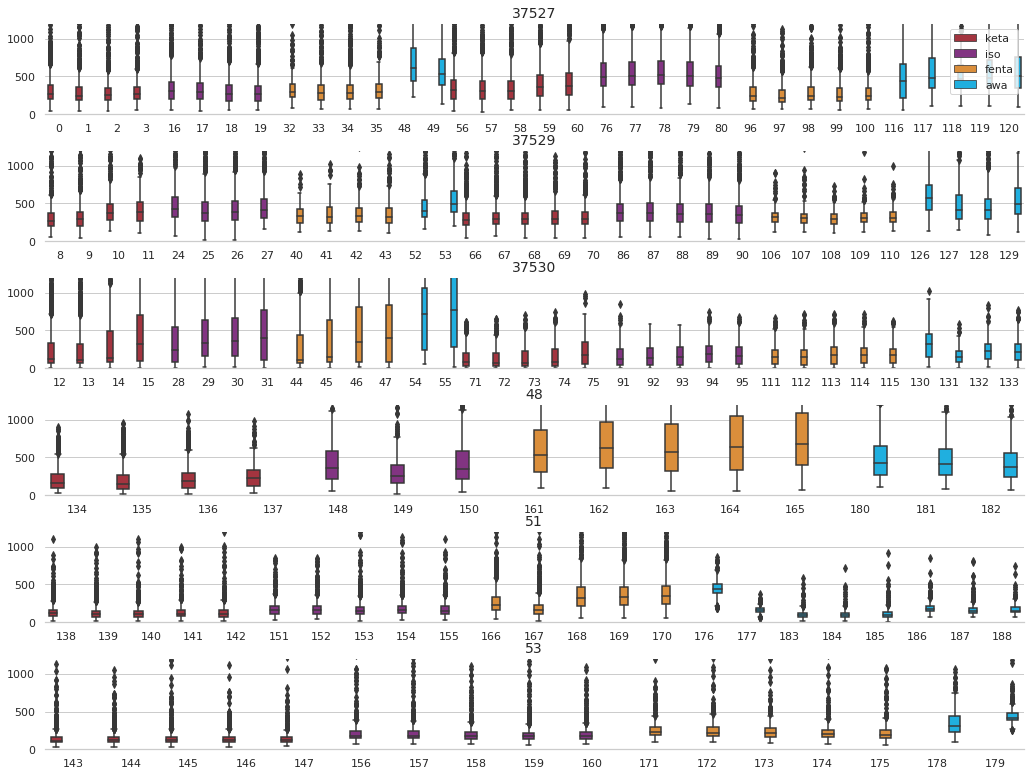

In [71]:
f, axes = plt.subplots(6, 1, figsize=(16, 12)) # sharex=Truerex=True
sns.despine(left=True)

#axes[0,0].set_ylim([0.1, 100.0])
#axes[0,1].set_ylim([60.0,140.0])
#axes[1,0].set_ylim([0.0,100.0])
#axes[1,1].set_ylim([0.0,2.0])

#axes[0,0].set_yscale('log')

for i, animal in enumerate(animals):
    sns.boxplot(x='recording', y='traces.median', data=df_estimators[df_estimators.animal == animal], hue='condition', \
                palette=(color_keta,color_iso,color_mmf,color_awake),ax=axes[i])
    axes[i].set_ylim([0.0,1200.0])
    axes[i].legend(loc='upper right')
    if i > 0:
        axes[i].get_legend().remove()
    axes[i].set_title(str(animal),fontsize='14')
    axes[i].xaxis.label.set_visible(False)
    axes[i].yaxis.label.set_visible(False)


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.35)

plt.show()

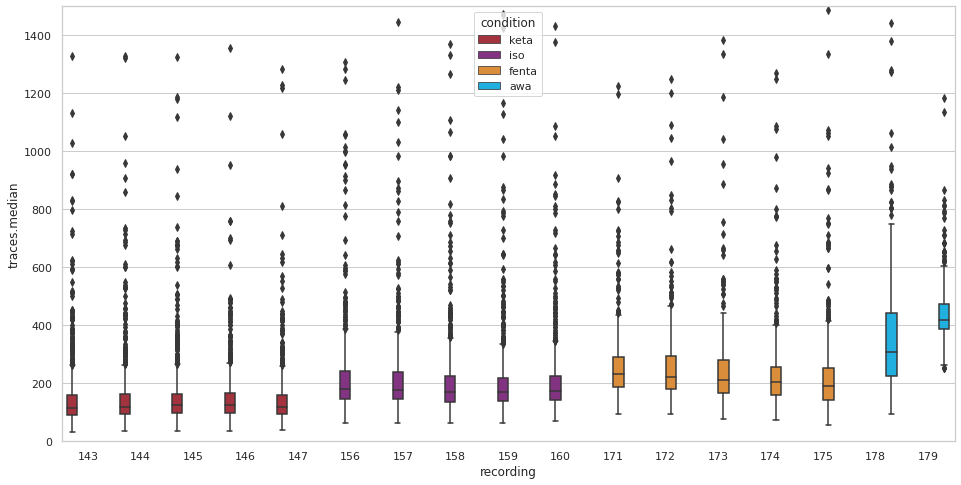

In [22]:
plt.rcParams['figure.figsize'] = [16, 8]


sns.boxplot(x='recording', y='traces.median', data=df_estimators[df_estimators.animal == 53], hue='condition',palette=(color_keta,color_iso,color_mmf,color_awake))
plt.ylim([0,1500])
#plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

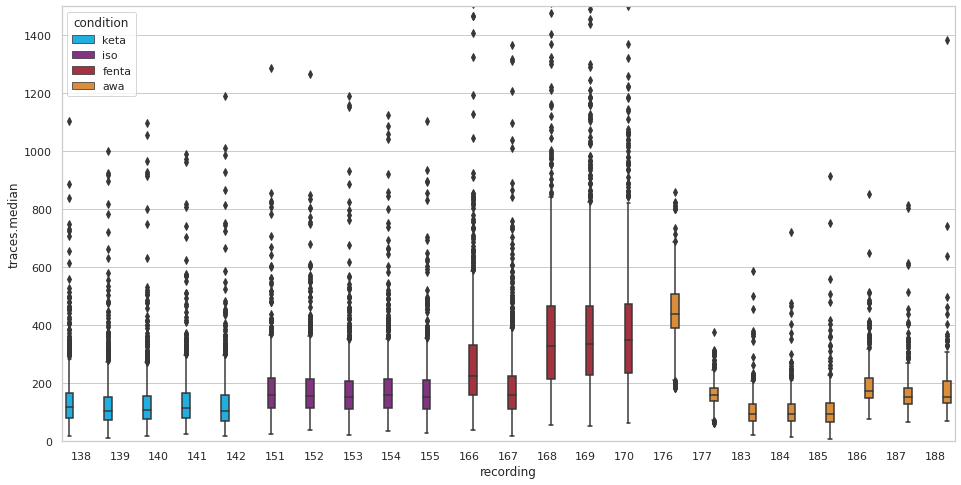

In [19]:
plt.rcParams['figure.figsize'] = [16, 8]

sns.boxplot(x='recording', y='traces.median', data=df_estimators[df_estimators.animal == 51], hue='condition',palette=(color_awake,color_iso,color_keta,color_mmf))
plt.ylim([0,1500])
#plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

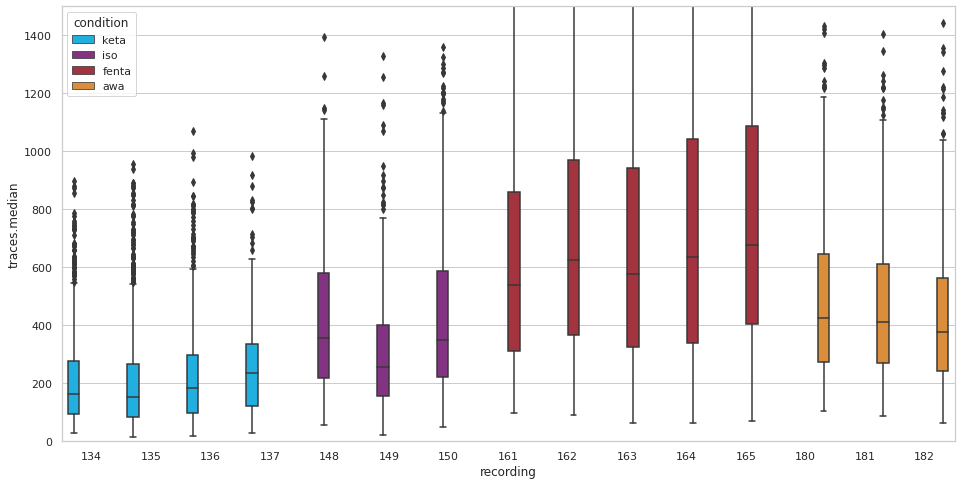

In [20]:
plt.rcParams['figure.figsize'] = [16, 8]

sns.boxplot(x='recording', y='traces.median', data=df_estimators[df_estimators.animal == 48], hue='condition',palette=(color_awake,color_iso,color_keta,color_mmf))
plt.ylim([0,1500])
#plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

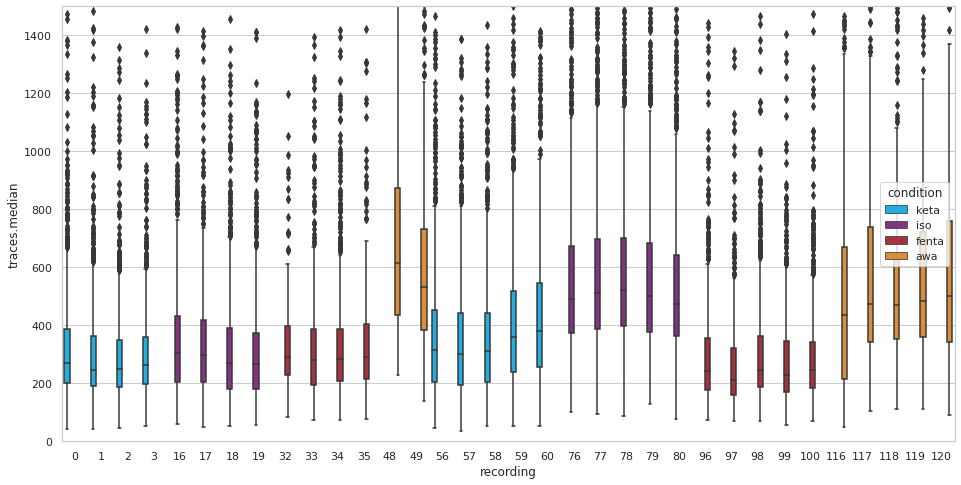

In [21]:
plt.rcParams['figure.figsize'] = [16, 8]

sns.boxplot(x='recording', y='traces.median', data=df_estimators[df_estimators.animal == 37527], hue='condition',palette=(color_awake,color_iso,color_keta,color_mmf))
plt.ylim([0,1500])
#plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

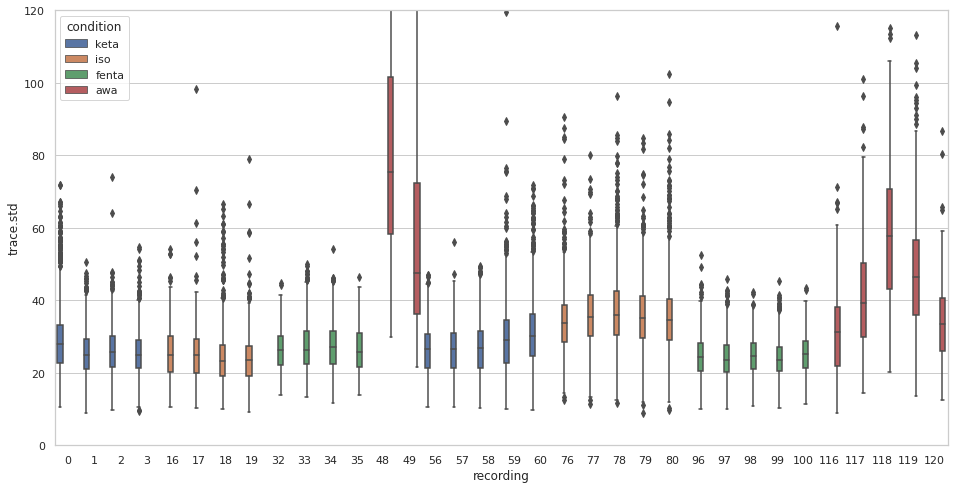

In [69]:
plt.rcParams['figure.figsize'] = [16, 8]

sns.boxplot(x='recording', y='trace.std', data=df_estimators, hue='condition')
plt.ylim([0,120])
#plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

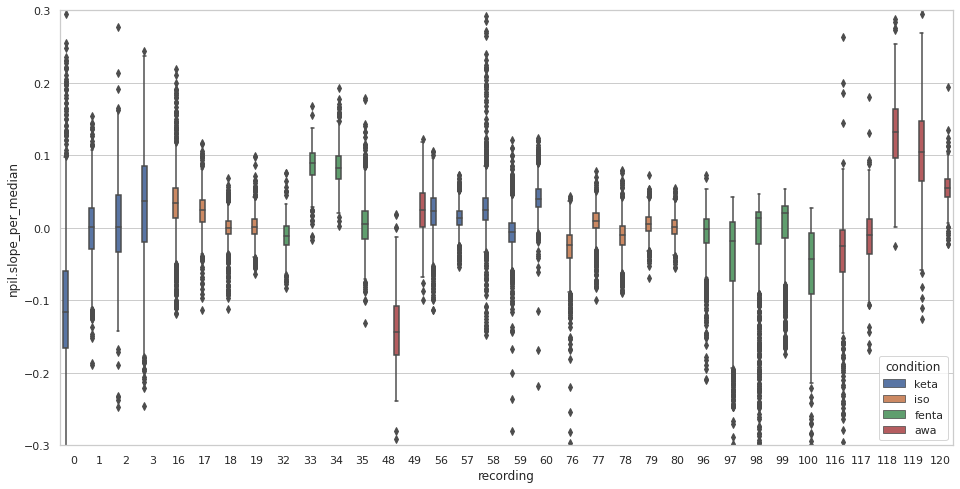

In [63]:
plt.rcParams['figure.figsize'] = [16, 8]
sns.boxplot(x='recording', y='npil.slope_per_median', data=df_estimators, hue='condition')
plt.ylim([-0.3,0.3])
#plt.title("Tm0p7Ncorr.mean; animals: " + str(np.unique(df_npil_stat_newdata['animal'])))
plt.show()

# Correlation of estimators

In [74]:
data = df_estimators[['n_peaks','trace.std','traces.median','trace.skewness','recording','trace.kurtosis','height.median','width.median']]
data = data[data['recording']==16]
data = data[['n_peaks','trace.std','traces.median','trace.skewness','trace.kurtosis','height.median','width.median']]

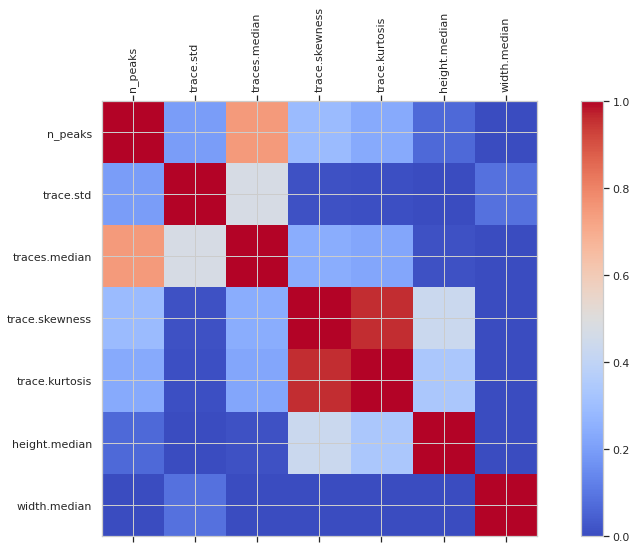

In [75]:
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=0, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()